<a href="https://colab.research.google.com/github/CLPF/Alpha-Fold-2/blob/master/AlphaFold2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ColabFold: AlphaFold2 w/ MMseqs2

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="256" align="right" style="height:256px">

Easy to use AlphaFold2 protein structure [(Jumper et al. 2021)](https://www.nature.com/articles/s41586-021-03819-2) and complex [(Evans et al. 2021)](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1) prediction using multiple sequence alignments generated through MMseqs2. For details, refer to our manuscript:

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold - Making protein folding accessible to all.
*bioRxiv*, 2021](https://www.biorxiv.org/content/10.1101/2021.08.15.456425v2) 

- This notebook provides basic functionality for **protein structure (Alphafold2)** and **complex prediction (Alphafold2-multimer)**. Advanced features such as recycles, sampling, ... ->[advanced notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/beta/AlphaFold2_advanced.ipynb).
- This notebook replaces the homology detection and MSA pairing of AlphaFold2 with MMseqs2. For a comparision against the [Deepmind Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) and the full [AlphaFold2](https://github.com/deepmind/alphafold) system read our [preprint](https://www.biorxiv.org/content/10.1101/2021.08.15.456425v1). 

Old versions: [v1.0-alpha](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.0-alpha/AlphaFold2.ipynb), [v1.1-permultimer](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.1-premultimer/AlphaFold2.ipynb)

For more details, see **<a href="#Instructions">bottom</a>** of the notebook and checkout the **[ColabFold GitHub](https://github.com/sokrypton/ColabFold)**.

In [1]:
#@title Input protein sequence, then hit `Runtime` -> `Run all`
from google.colab import files
import os.path
import re
import hashlib

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'SHMREESLQLMDLLGLERSAWGNIPLMRKAYLKKCKEFHPDKGGDEEKMKKMNTLYKKMEDGVKYAHQPDFGGFWDATEIPTYGTDEWEQWWNAFNEEN:LSFLSHAVFSNRTLACFAIYTTKEKAALLYKKIMEKYSVTFISRHNSYNHNILFFLTPHRHRVSAINNYAQKLCTFSFLICKGVNKEYLMYSALTRDPFSVIEESLPGGLKEHD' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a mono-dimer

# remove whitespaces
query_sequence = "".join(query_sequence.split())

jobname = 'Domain1-2 _SV40_s/linker' #@param {type:"string"}
# remove whitespaces
jobname = "".join(jobname.split())
jobname = re.sub(r'\W+', '', jobname)
jobname = add_hash(jobname, query_sequence)


with open(f"{jobname}.csv", "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{query_sequence}")

queries_path=f"{jobname}.csv"

# number of models to use
#@markdown ---
#@markdown ### Advanced settings
msa_mode = "MMseqs2 (UniRef+Environmental)" #@param ["MMseqs2 (UniRef+Environmental)", "MMseqs2 (UniRef only)","single_sequence","custom"]
num_models = 2 #@param [1,2,3,4,5] {type:"raw"}
num_recycles = 3 #@param [1,3,6,12,24,48] {type:"raw"}
use_msa = True if msa_mode.startswith("MMseqs2") else False
use_env = True if msa_mode == "MMseqs2 (UniRef+Environmental)" else False
use_amber = True #@param {type:"boolean"}
use_templates = False #@param {type:"boolean"}

#@markdown ---
#@markdown ### Experimental options
save_to_google_drive = False #@param {type:"boolean"}
#@markdown ---
#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

with open(f"{jobname}.log", "w") as text_file:
    text_file.write("num_models=%s\n" % num_models)
    text_file.write("use_amber=%s\n" % use_amber)
    text_file.write("use_msa=%s\n" % use_msa)
    text_file.write("msa_mode=%s\n" % msa_mode)
    text_file.write("use_templates=%s\n" % use_templates)

# decide which a3m to use
if use_msa:
  a3m_file = f"{jobname}.a3m"
elif msa_mode == "custom":
  a3m_file = f"{jobname}.custom.a3m"
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if line.startswith("#"):
        continue
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")
else:
  a3m_file = f"{jobname}.single_sequence.a3m"
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

In [2]:
#@title Install dependencies
%%bash -s $use_amber $use_msa $use_templates

set -e

USE_AMBER=$1
USE_MSA=$2
USE_TEMPLATES=$3

if [ ! -f COLABFOLD_READY ]; then
  # install dependencies
  pip install -q biopython dm-haiku ml-collections py3Dmol
  # Trick for dev stage because otherwise pip won't install newer git versions
  pip uninstall -y -q colabfold
  pip install -q "colabfold[alphafold] @ git+https://github.com/sokrypton/ColabFold"
  touch COLABFOLD_READY
fi

# download libraries for interfacing with MMseqs2 API
if [ ${USE_MSA} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f MMSEQ2_READY ]; then
    apt-get -qq -y update 2>&1 1>/dev/null
    apt-get -qq -y install jq curl zlib1g gawk 2>&1 1>/dev/null
    touch MMSEQ2_READY
  fi
fi
# setup conda
if [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f CONDA_READY ]; then
    wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
    rm Miniconda3-latest-Linux-x86_64.sh
    touch CONDA_READY
  fi
fi
# setup template search
if [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then
  conda install -y -q -c conda-forge -c bioconda kalign3=3.2.2 hhsuite=3.3.0 python=3.7 2>&1 1>/dev/null
  touch HH_READY
fi
# setup openmm for amber refinement
if [ ${USE_AMBER} == "True" ] && [ ! -f AMBER_READY ]; then
  conda install -y -q -c conda-forge openmm=7.5.1 python=3.7 pdbfixer 2>&1 1>/dev/null
  wget -qnc https://raw.githubusercontent.com/deepmind/alphafold/main/docker/openmm.patch
  (cd /usr/local/lib/python3.7/site-packages; patch -s -p0 < /content/openmm.patch)
  wget -qnc https://git.scicore.unibas.ch/schwede/openstructure/-/raw/7102c63615b64735c4941278d92b554ec94415f8/modules/mol/alg/src/stereo_chemical_props.txt
  touch AMBER_READY
fi

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.4.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.13.0 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.4 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
#@title Run Prediction

import sys

from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run

from pathlib import Path

# For some reason we need that to get pdbfixer to import
if use_amber and '/usr/local/lib/python3.7/site-packages/' not in sys.path:
    sys.path.insert(0, '/usr/local/lib/python3.7/site-packages/')

result_dir="."
setup_logging(Path(".").joinpath("log.txt"))
queries, is_complex = get_queries(queries_path)
download_alphafold_params(is_complex, Path("."))
run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    use_amber=use_amber,
    msa_mode=msa_mode,
    num_models=num_models,
    num_recycles=num_recycles,
    model_order=[1, 2, 3, 4, 5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    recompile_padding=1.0,
    rank_mode="auto",
    pair_mode="unpaired+paired",
    stop_at_score=float(100),
)

/usr/local/lib/python3.7/dist-packages/colabfold/colabfold.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


2021-11-23 22:27:12,529 Found 6 citations for tools or databases
2021-11-23 22:27:19,168 Query 1/1: Domain12_SV40_slinker_ae10d (length 213)


  0%|          | 0/300 [elapsed: 00:00 remaining: ?]

2021-11-23 22:27:19,897 Sleeping for 7s. Reason: PENDING
2021-11-23 22:27:27,435 Sleeping for 8s. Reason: RUNNING
2021-11-23 22:27:35,975 Sleeping for 10s. Reason: RUNNING
2021-11-23 22:27:46,519 Sleeping for 10s. Reason: RUNNING
2021-11-23 22:27:57,045 Sleeping for 10s. Reason: RUNNING
2021-11-23 22:28:07,586 Sleeping for 8s. Reason: RUNNING
2021-11-23 22:28:16,075 Sleeping for 10s. Reason: RUNNING


  0%|          | 0/300 [elapsed: 00:00 remaining: ?]

2021-11-23 22:28:28,310 Sleeping for 10s. Reason: PENDING
2021-11-23 22:28:38,913 Sleeping for 6s. Reason: RUNNING
2021-11-23 22:28:46,342 Running model_1
2021-11-23 22:33:44,073 model_1 took 0.0s with pLDDT 69.3
2021-11-23 23:06:26,394 Running model_2
2021-11-23 23:08:02,533 model_2 took 0.0s with pLDDT 69.2
2021-11-23 23:10:58,893 reranking models based on avg. predicted lDDT
2021-11-23 23:10:59,567 Done


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

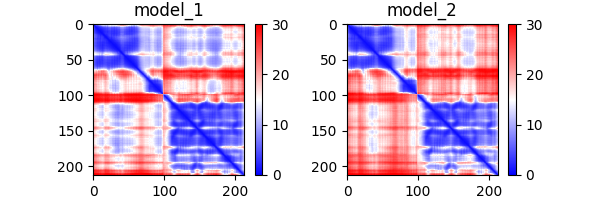

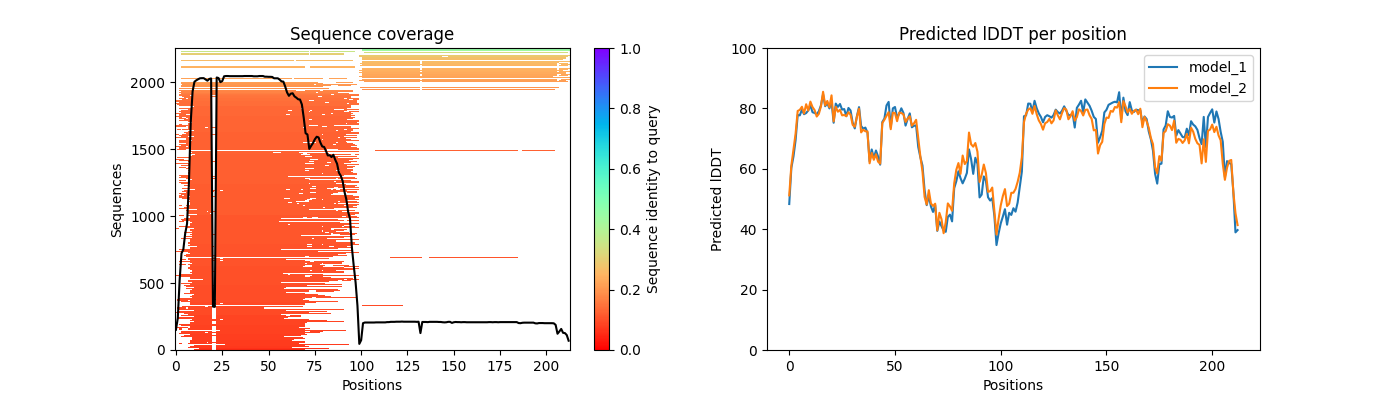

In [4]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

jobname_prefix = ".custom" if msa_mode == "custom" else ""
if use_amber:
  pdb_filename = f"{jobname}{jobname_prefix}_relaxed_model_*_rank_{rank_num}.pdb"
else:
  pdb_filename = f"{jobname}{jobname_prefix}_unrelaxed_model_*_rank_{rank_num}.pdb"

pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  if use_amber:
    pdb_filename = f"{jobname}{jobname_prefix}_relaxed_{model_name}.pdb"
  else:
    pdb_filename = f"{jobname}{jobname_prefix}_unrelaxed_{model_name}.pdb"

  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(homooligomer),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view


show_pdb(rank_num,show_sidechains, show_mainchains, color).show()

from IPython.display import Image
from IPython.display import display

pae = Image(f"{jobname}{jobname_prefix}_PAE.png")
plddt = Image(f"{jobname}{jobname_prefix}_coverage_lDDT.png")
display(pae, plddt)



In [5]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")
if msa_mode != "custom":
  !cat $jobname"_env/"*".a3m" > $jobname".a3m"
!zip -FSr $jobname".result.zip" $jobname".log" $a3m_file $jobname*"relaxed_model_"*".pdb" $jobname*"_coverage_lDDT.png" "cite.bibtex" $jobname*"_PAE.png"
files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

  adding: Domain12_SV40_slinker_ae10d.log (deflated 15%)
  adding: Domain12_SV40_slinker_ae10d.a3m (deflated 61%)
  adding: Domain12_SV40_slinker_ae10d_relaxed_model_1_rank_1.pdb (deflated 78%)
  adding: Domain12_SV40_slinker_ae10d_relaxed_model_2_rank_2.pdb (deflated 78%)
  adding: Domain12_SV40_slinker_ae10d_unrelaxed_model_1_rank_1.pdb (deflated 78%)
  adding: Domain12_SV40_slinker_ae10d_unrelaxed_model_2_rank_2.pdb (deflated 78%)
  adding: Domain12_SV40_slinker_ae10d_coverage_lDDT.png (deflated 4%)
  adding: cite.bibtex (deflated 53%)
  adding: Domain12_SV40_slinker_ae10d_PAE.png (deflated 1%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Instructions <a name="Instructions"></a>
**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running steps is indicated by a circle with a stop sign next to it.

**Result zip file contents**

1. PDB formatted structures sorted by avg. pIDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled). 
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**MSA generation for complexes**

For the complex prediction we use unpaired and paired MSAs. Unpaired MSA is generated the same way as for the protein structures prediction by searching the UniRef100 and environmental sequences three iterations each.

The paired MSA is generated by searching the UniRef100 database and pairing the best hits sharing the same NCBI taxonomical identifier (=species or sub-species). We only pair sequences if all of the query sequences are present for the respective taxonomical identifier.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted): (1) Change the msa_mode: to "custom", (2) Wait for an upload box to appear at the end of the "Input Protein ..." box. Upload your A3M. The first fasta entry of the A3M must be the query sequence without gaps.

As an alternative for MSA generation the [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits) can be used. After submitting your query, click "Query Template MSA" -> "Download Full A3M". Download the A3M file and upload it in this notebook.

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or Mgnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues


**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software. 

- [Söding Lab](https://www.mpibpc.mpg.de/soeding) for providing the computational resources for the MMseqs2 server

- Richard Evans for helping to bechmark the ColabFold's Alphafold-multimer support

- [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).
